<a href="https://colab.research.google.com/github/jiheddachraoui/Covid19-ultrasound-video-scoring/blob/main/Database_ordering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importations

In [ ]:
import sys 
from google.colab import drive
drive.mount('/content/gdrive')
from datetime import timedelta
import cv2
import numpy as np
import os
import shutil
import matplotlib.pyplot as plt
import pandas as pd
import random
from sklearn.model_selection import KFold 
from sklearn.metrics import accuracy_score
from scipy.io import loadmat


Mounted at /content/gdrive


# Copying Data to Drive

In [ ]:
source_dir = r"/content/gdrive/MyDrive/Dati San Matteo Dataset 2"
destination_dir = r"/content/gdrive/MyDrive/Dataset"
#create a copy of the dataset
#shutil.copytree(source_dir, destination_dir)

## Copying all data in one folder

###videos

In [ ]:
folder_path = "/content/gdrive/MyDrive/Dataset"
if os.path.exists("/content/gdrive/MyDrive/Dataset/videos"):
  shutil.rmtree("/content/gdrive/MyDrive/Dataset/videos")
files = [f for f in os.listdir(folder_path) if not os.path.isfile(os.path.join(folder_path, f))]
exams=[]
videos=[]
vid_path=[]
for f in files:
    path = os.path.join(folder_path,f)
    for e in os.listdir(path):

      if not os.path.isfile(os.path.join(path, e)):
        exams.append(e)
        path1 = os.path.join(path,e)
        
        for v in os.listdir(path1):
          
          if os.path.isfile(os.path.join(path1, v)) and v.split('.')[1]=="avi" :
            videos.append(v)
            vid_path.append(path1)
            
 
#len(videos)
len(vid_path)



In [ ]:
i=0
for video in videos:
    folder_type = video.split('.')[1]
    patient_name = video.split('_')[1]
    exam = video.split('_')[2]
    new_path = os.path.join(videos_path, patient_name+'-'+exam)
    if not os.path.exists(new_path):
        os.makedirs(new_path)
    
    old_video_path = os.path.join(vid_path[i], video)
    new_video_path = os.path.join(new_path, video)
    if not os.path.exists(new_video_path):
      shutil.copy(old_video_path, new_video_path)
      print('video',video ,'added to',new_video_path)
    i+=1

### videos frames

In [ ]:
folder_path = "/content/gdrive/MyDrive/Dataset"

files = [f for f in os.listdir(folder_path) if not os.path.isfile(os.path.join(folder_path, f))]
exams=[]
frames=[]
f_path=[]
for f in files:
    path = os.path.join(folder_path,f)
    for e in os.listdir(path):

      if not os.path.isfile(os.path.join(path, e)):
        exams.append(e)
        path1 = os.path.join(path,e)
        
        for v in os.listdir(path1):
          
          if os.path.isfile(os.path.join(path1, v)) and v.split('.')[1]=="mat" and len(v.split('_'))==4 :
            
            frames.append(v)
            f_path.append(os.path.join(path1, v))
            
 
#len(videos)
len(f_path)


In [ ]:
frames_path='/content/gdrive/MyDrive/Dataset/frames'
i=0

for f in frames:
    folder_type = f.split('.')[1]
    patient_name = f.split('_')[1]
    exam = f.split('_')[2]
    new_path = os.path.join(frames_path, patient_name+'-'+exam)
    if not os.path.exists(new_path):
        os.makedirs(new_path)
    
    old_file_path = f_path[i]
    new_file_path = os.path.join(new_path, f)
    if not os.path.exists(new_file_path):
      shutil.copy(old_file_path, new_file_path)
      print('video frames',f ,'added to',new_file_path)
    i+=1

# Frames extraction

In [ ]:
SAVING_FRAMES_PER_SECOND = 10
def format_timedelta(td):
    """Utility function to format timedelta objects in a cool way (e.g 00:00:20.05) 
    omitting microseconds and retaining milliseconds"""
    result = str(td)
    try:
        result, ms = result.split(".")
    except ValueError:
        return result + ".00".replace(":", "-")
    ms = int(ms)
    ms = round(ms / 1e4)
    return f"{result}.{ms:02}".replace(":", "-")


def get_saving_frames_durations(cap, saving_fps):
    """A function that returns the list of durations where to save the frames"""
    s = []
    # get the clip duration by dividing number of frames by the number of frames per second
    clip_duration = cap.get(cv2.CAP_PROP_FRAME_COUNT) / cap.get(cv2.CAP_PROP_FPS)
    # use np.arange() to make floating-point steps
    for i in np.arange(0, clip_duration, 1 / saving_fps):
        s.append(i)
    return s

In [ ]:
def extract(video_file):
    filename, _ = os.path.splitext(video_file)
    filename += "-Frames"
    print(filename)
    # make a folder by the name of the video file
    if not os.path.isdir(filename):
        os.mkdir(filename)
    # read the video file    
    cap = cv2.VideoCapture(video_file)
    # get the FPS of the video
    fps = cap.get(cv2.CAP_PROP_FPS)
    # if the SAVING_FRAMES_PER_SECOND is above video FPS, then set it to FPS (as maximum)
    saving_frames_per_second = min(fps, SAVING_FRAMES_PER_SECOND)
    # get the list of duration spots to save
    saving_frames_durations = get_saving_frames_durations(cap, saving_frames_per_second)
    # start the loop
    count = 0
    while True:
        is_read, frame = cap.read()
        if not is_read:
            # break out of the loop if there are no frames to read
            break
        # get the duration by dividing the frame count by the FPS
        frame_duration = count / fps
        try:
            # get the earliest duration to save
            closest_duration = saving_frames_durations[0]
        except IndexError:
            # the list is empty, all duration frames were saved
            break
        if frame_duration >= closest_duration:
            # if closest duration is less than or equals the frame duration, 
            # then save the frame
            frame_duration_formatted = format_timedelta(timedelta(seconds=frame_duration))
            cv2.imwrite(os.path.join(filename, f"frame{frame_duration_formatted}.jpg"), frame)
            print(os.path.join(filename, f"frame{frame_duration_formatted}.jpg"), 'saved') 
            # drop the duration spot from the list, since this duration spot is already saved
            try:
                saving_frames_durations.pop(0)
            except IndexError:
                pass
        # increment the frame count
        count += 1

In [ ]:
videos_path='/content/gdrive/MyDrive/Dataset/videos'
video_files=[]
files = [os.path.join(videos_path,f) for f in os.listdir(videos_path)]
for f in files:
  for v in os.listdir(f):
    if os.path.isfile(os.path.join(f,v)):
      video_file=os.path.join(f,v)
      video_files.append(video_file)
    

for video_file in video_files:
  extract(video_file) 
  print('next video__________________________________________________________________________')

# Count files in folder

In [ ]:
def count_files(path):
  count = 0

  for f in os.listdir(path):
      # check if current path is a file
      if os.path.isfile(os.path.join(path, f)):
          count += 1
  #print('File count:', count)
  return count


# Max-Min images generator

In [ ]:

def vid_max_min_frame_generator(vid_path):
  filename, _ = os.path.splitext(video_file)
  filename += "-MAXMIN"
  if not os.path.isdir(filename):
        os.mkdir(filename)
  cap = cv2.VideoCapture(vid_path)
  frameCount = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
  frameWidth = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
  frameHeight = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

  buf = np.empty((frameCount, frameHeight, frameWidth, 3), np.dtype('uint8'))

  fc = 0
  ret = True

  while (fc < frameCount  and ret):
      ret, buf[fc] = cap.read()
      fc += 1

  cap.release()
  
  try:
    Max=np.max(buf,axis=0)
    Min=np.min(buf,axis=0)
   
    #plt.imshow(Max)
    #print(Max.shape)
  
    #plt.show()
    #plt.imshow(Min)
    #print(Min.shape)
    #plt.show()
    cv2.imwrite(os.path.join(filename,"Max.jpg"), Max)
    print(os.path.join(filename,"-Max.jpg"))
    cv2.imwrite(os.path.join(filename,"Min.jpg"), Min)
    print(os.path.join(filename,"-Min.jpg"), 'saved')
  
  except ValueError:  
      pass
 ################################################################





def matrix_max_min_frame_generator(file_path):
  filename=file_path.split('/')[-1]
  filename=filename.split('.')[0]
  filename1, _ = os.path.splitext(file_path)
  filename1 =filename1+ "-MAXMIN"
  
  if not os.path.isdir(filename1):
        os.mkdir(filename1)
  f = loadmat(file_path)
  frames=f['frames']
  #frames.shape
  
  Max=np.max(frames,axis=3)
  Min=np.min(frames,axis=3)
  #plt.imshow(Max)
  #print(Max.shape)
 # plt.show()
  #plt.imshow(Min)
  #print(Min.shape)
  #plt.show()
  if not os.path.exists(os.path.join(filename1,f"{filename}-Max.jpg")) :
    cv2.imwrite(os.path.join(filename1,f"{filename}-Max.jpg"), Max)
    print(os.path.join(filename1,f"{filename}-Max.jpg"))
  if not os.path.exists(os.path.join(filename1,f"{filename}-Min.jpg")) :
    cv2.imwrite(os.path.join(filename1,f"{filename}-Min.jpg"), Min)
    print(os.path.join(filename1,f"{filename}-Min.jpg"), 'saved')
  
  
 

# Crop Image

In [ ]:

# Importing Image class from PIL module
from PIL import Image
import matplotlib.pyplot as plt
# Opens a image in RGB mode
def crop(image):
  im = Image.open(image)
 
  # Setting the points for cropped image
  width, height = im.size
 
  # Setting the points for cropped image
  left = 400
  top = 60
  right = 1030
  bottom=570
  # Cropped image of above dimension
  # (It will not change original image)
  im1 = im.crop((left, top, right, bottom))
 
  # Shows the image in image viewer
  plt.imshow(im)
  plt.show()
  plt.imshow(im1)
  plt.show()
  

# Data analysis 


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f095f450510>,
      dtype=object)

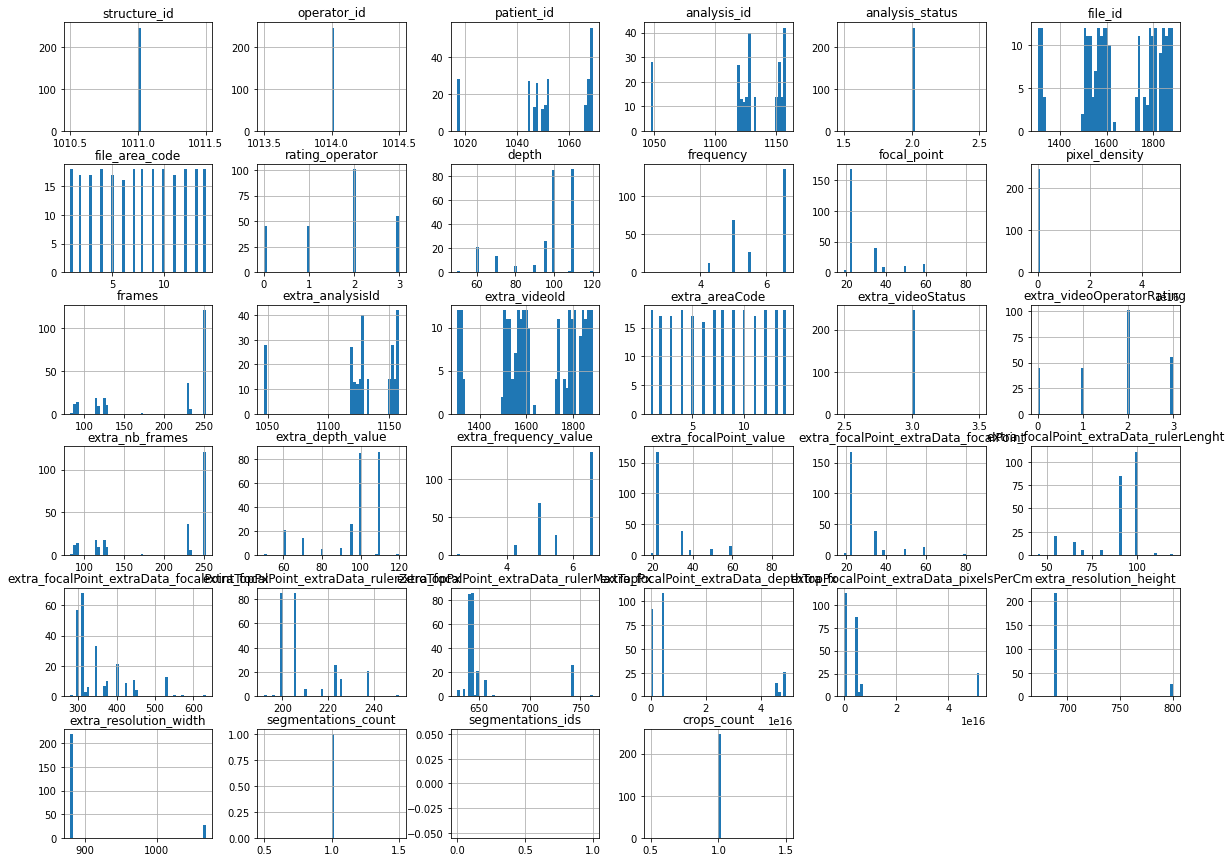

In [ ]:
df=pd.read_csv('/content/gdrive/MyDrive/Dataset/SanMatteo.csv')

df.hist(bins=50,figsize=(20,15))

In [ ]:
df2=df[['patient_id','analysis_id','file_area_code','rating_operator']]


#df2.sort_values(by=['rating_operator'])
df2['video'] ='convex_' +df2['patient_id'].astype(str) + '_' + df2['analysis_id'].astype(str)+ '_' + df2['file_area_code'].astype(str)
#df2=df2.set_index(['patient_id','analysis_id','file_area_code'])
df2=df2[['video','rating_operator']]
#df2=df2.set_index(['video'])
df2=df2.reset_index(drop=True)

df2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,video,rating_operator
0,convex_1017_1047_1,2
1,convex_1017_1047_2,1
2,convex_1017_1047_3,2
3,convex_1017_1047_4,1
4,convex_1017_1047_5,2
...,...,...
241,convex_1069_1158_10,1
242,convex_1069_1158_11,1
243,convex_1069_1158_12,1
244,convex_1069_1158_13,1


In [ ]:
s0=df2[df2['rating_operator']==0]
s0.head()

,video,rating_operator
30,convex_1045_1119_3,0
33,convex_1045_1119_6,0
39,convex_1045_1119_12,0
40,convex_1045_1119_13,0
41,convex_1045_1119_14,0


In [ ]:
s1=df2[df2['rating_operator']==1]
s1.head()

,video,rating_operator
1,convex_1017_1047_2,1
3,convex_1017_1047_4,1
5,convex_1017_1047_6,1
12,convex_1017_1047_13,1
25,convex_1017_1048_12,1


In [ ]:
s2=df2[df2['rating_operator']==2]
s2.head()

,video,rating_operator
0,convex_1017_1047_1,2
2,convex_1017_1047_3,2
4,convex_1017_1047_5,2
6,convex_1017_1047_7,2
7,convex_1017_1047_8,2


In [ ]:
s3=df2[df2['rating_operator']==3]
s3.head()

,video,rating_operator
17,convex_1017_1048_4,3
20,convex_1017_1048_7,3
21,convex_1017_1048_8,3
28,convex_1045_1119_1,3
58,convex_1047_1122_4,3


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f09637d3490>]],
      dtype=object)

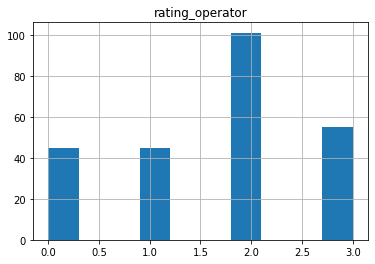

In [ ]:
df2.hist()

# Data label organization

In [ ]:
#these parameters are defined in the previous section
score0 = s0.to_dict(orient = 'list')
score1 = s1.to_dict(orient = 'list')
score2 = s2.to_dict(orient = 'list')
score3 = s3.to_dict(orient = 'list')

video0=score0['video']
video1=score1['video']
video2=score2['video']
video3=score3['video']
total=video0+video1+video2+video3
print(video2)

['convex_1017_1047_1', 'convex_1017_1047_3', 'convex_1017_1047_5', 'convex_1017_1047_7', 'convex_1017_1047_8', 'convex_1017_1047_9', 'convex_1017_1047_10', 'convex_1017_1047_11', 'convex_1017_1047_12', 'convex_1017_1047_14', 'convex_1017_1048_1', 'convex_1017_1048_2', 'convex_1017_1048_3', 'convex_1017_1048_5', 'convex_1017_1048_6', 'convex_1017_1048_9', 'convex_1017_1048_10', 'convex_1017_1048_11', 'convex_1017_1048_13', 'convex_1045_1119_4', 'convex_1045_1119_7', 'convex_1045_1119_8', 'convex_1045_1119_9', 'convex_1045_1119_10', 'convex_1045_1119_11', 'convex_1045_1120_4', 'convex_1047_1122_1', 'convex_1047_1122_2', 'convex_1047_1122_3', 'convex_1047_1122_6', 'convex_1047_1122_7', 'convex_1047_1122_9', 'convex_1047_1122_12', 'convex_1048_1124_8', 'convex_1048_1124_10', 'convex_1048_1124_11', 'convex_1048_1124_14', 'convex_1048_1126_2', 'convex_1048_1126_3', 'convex_1048_1126_7', 'convex_1048_1126_10', 'convex_1050_1127_5', 'convex_1050_1127_7', 'convex_1050_1127_8', 'convex_1050_1127

In [ ]:

def score_folder(List,s):
  
  root_dir = '/content/gdrive/MyDrive/Dataset/data/'
  path0=root_dir+s+'/score0'
  path1=root_dir+s+'/score1'
  path2=root_dir+s+'/score2'
  path3=root_dir+s+'/score3'
  path=[path0,path1,path2,path3]
  videos_path=root_dir+s
  for i in path:
    if not os.path.exists(i):
          os.mkdir(i)
  
  files = [f for f in os.listdir(videos_path)]
  print(files)
  for v in files:
    
      #print(os.path.join(videos_path,v))
      if os.path.isfile(os.path.join(videos_path,v)):
        
        
        
        if v.split('.')[0] in video0 :
       

            if not os.path.exists(os.path.join(path0, v)):
             
              #os.mkdir(path=os.path.join(path, v))
              shutil.copy(os.path.join(videos_path,v), os.path.join(path0, v))

        elif v.split('.')[0] in video1 :
       

            if not os.path.exists(os.path.join(path1, v)):
              
              #os.mkdir(path=os.path.join(path, v))
              shutil.copy(os.path.join(videos_path,v), os.path.join(path1, v))

        elif v.split('.')[0] in video2 :
       

            if not os.path.exists(os.path.join(path2, v)):
             
              #os.mkdir(path=os.path.join(path, v))
              shutil.copy(os.path.join(videos_path,v), os.path.join(path2, v))
   
        elif v.split('.')[0] in video3 :
       

            if not os.path.exists(os.path.join(path3, v)):
              
              #os.mkdir(path=os.path.join(path, v))
              shutil.copy(os.path.join(videos_path,v), os.path.join(path3, v))
              #copy
  
  

'''score_folder('score0',video0,'train')
score_folder('score1',video1,'train')
score_folder('score2',video2,'train')
score_folder('score3',video3,'train')

score_folder('score0',video0,'val')
score_folder('score1',video1,'val')
score_folder('score2',video2,'val')
score_folder('score3',video3,'val')

score_folder('score0',video0,'test')
score_folder('score1',video1,'test')
score_folder('score2',video2,'test')
score_folder('score3',video3,'test')

print('folders with no score',set(x) )
#print(count_files(path0)+count_files(path1)+count_files(path2)+count_files(path3))'''

"score_folder('score0',video0,'train')\nscore_folder('score1',video1,'train')\nscore_folder('score2',video2,'train')\nscore_folder('score3',video3,'train')\n\nscore_folder('score0',video0,'val')\nscore_folder('score1',video1,'val')\nscore_folder('score2',video2,'val')\nscore_folder('score3',video3,'val')\n\nscore_folder('score0',video0,'test')\nscore_folder('score1',video1,'test')\nscore_folder('score2',video2,'test')\nscore_folder('score3',video3,'test')\n\nprint('folders with no score',set(x) )\n#print(count_files(path0)+count_files(path1)+count_files(path2)+count_files(path3))"

In [ ]:
"""frames_path='/content/gdrive/MyDrive/Dataset/frames score'
frames_files=[]
files = [os.path.join(frames_path,f) for f in os.listdir(frames_path)]
for f in files:
  for v in os.listdir(f):
    if os.path.isfile(os.path.join(f,v)):
      file=os.path.join(f,v)
      frames_files.append(file)
    

for file in frames_files:
  matrix_max_min_frame_generator(file) 
  print('next file__________________________________________________________________________')"""

"frames_path='/content/gdrive/MyDrive/Dataset/frames score'\nframes_files=[]\nfiles = [os.path.join(frames_path,f) for f in os.listdir(frames_path)]\nfor f in files:\n  for v in os.listdir(f):\n    if os.path.isfile(os.path.join(f,v)):\n      file=os.path.join(f,v)\n      frames_files.append(file)\n    \n\nfor file in frames_files:\n  matrix_max_min_frame_generator(file) \n  print('next file__________________________________________________________________________')"

# Missing scores

In [ ]:
videos_path='/content/gdrive/MyDrive/Dataset/frames'
x=[]
m=[]
videos=[]

for root, dirs, files in os.walk(videos_path, topdown=False):
   for v in files:
     videos.append(v.split('.')[0])
     if v.split('.')[0] not in total :
          x.append(v.split('.')[0])
print('videos without label= ',x)     
  
for i in total:
  if i not in videos:
    m.append(i)

print('labels without video=',m)   

# Data split

## K-fold


In [ ]:
k=5
df=pd.read_csv('/content/gdrive/MyDrive/Dataset/SanMatteo.csv')
df=df[['patient_id','analysis_id','file_area_code','rating_operator']]

TRAIN_SPLIT_PERC = 0.7  #0.7
VALID_SPLIT_PERC = 0.21 #0.21
folds=[]
id="patient_id"
for i in range(k):
    
    uniques = df[id].unique()
    random.shuffle(uniques)
    step = int(len(uniques) * TRAIN_SPLIT_PERC)
    step1=int(len(uniques) * (TRAIN_SPLIT_PERC+VALID_SPLIT_PERC))
    df = df.sample(frac=1).reset_index(drop=True) #shuffling data
    train_ids, valid_ids,test_ids = uniques[:step], uniques[step:step1],uniques[step1:]
    


   
    fold=[list(train_ids),list(valid_ids),list(test_ids)]
    
    folds.append(fold)
print(folds)

print(folds[1])


  

In [ ]:
train = [folds[i][0] for i in range(len(folds))] 
valid = [folds[i][1] for i in range(len(folds))] 
test = [folds[i][2] for i in range(len(folds))] 
     
# dictionary of lists  
dict = {'train': train, 'valid': valid, 'test': test}  
       
cv = pd.DataFrame(dict) 
    
# saving the dataframe 
if not os.path.exists('/content/gdrive/MyDrive/Dataset/folds.csv'):
  cv.to_csv('/content/gdrive/MyDrive/Dataset/folds.csv') 

NameError: ignored

In [ ]:
'''df=pd.read_csv('/content/gdrive/MyDrive/Dataset/folds.csv')
train=df['train']
train_ids = train.to_list()
score1 = s1.to_dict(orient = 'list')
score2 = s2.to_dict(orient = 'list')
score3 = s3.to_dict(orient = 'list')
train_ids[0].split()'''

In [ ]:
folds=[
    [[1017, 1050, 1069, 1045, 1051, 1066, 1052],[1048, 1051, 1052],[1067]], [[1017, 1050, 1069, 1045, 1051, 1066, 1052],[1067, 1047, 1068],[1048]],

    ]
fold_num=1
train_ids, valid_ids,test_ids = folds[fold_num][0],folds[fold_num][1],folds[fold_num][2]
train_df,  valid_df ,test_df = df[df.patient_id.isin(train_ids)],df[df.patient_id.isin(valid_ids)], df[df.patient_id.isin(test_ids)]
'''
print("\nTRAIN DATA\n", train_df.shape)
print("\nVALID DATA\n", valid_df.shape)
print("\nTEST DATA\n", test_df.shape)
'''
D=[train_df,valid_df,test_df]
for d in D:
  d['video'] ='convex_' +d['patient_id'].astype(str) + '_' + d['analysis_id'].astype(str)+ '_' + d['file_area_code'].astype(str)

  d=d[['video','rating_operator']]
  d=d.reset_index(drop=True)


train = train_df.to_dict(orient = 'list')
valid = valid_df.to_dict(orient = 'list')
test = test_df.to_dict(orient = 'list')
train=train['video']
valid=valid['video']
test=test['video']
cv=pd.DataFrame(test) 
if not os.path.exists('/content/gdrive/MyDrive/Dataset/test.csv'):
  cv.to_csv('/content/gdrive/MyDrive/Dataset/test.csv')


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


## split the folders

In [ ]:
root_dir = '/content/gdrive/MyDrive/Dataset/data/'
videos_path='/content/gdrive/MyDrive/Dataset/frames'
l=['train','valid','test']
L=[train,valid,test]
j=0
for i in l:
  if not os.path.exists(os.path.join(root_dir, i)):
            os.mkdir(path=os.path.join(root_dir, i))



for List in L:
  path=os.path.join(root_dir, l[j])
  video_files=[]
  files = [os.path.join(videos_path,f) for f in os.listdir(videos_path) ]
  for f in files:
    for v in os.listdir(f):
      if os.path.isfile(os.path.join(f,v)):
       video_file=os.path.join(f,v)
       video_files.append(video_file)
       
        
        
      if v.split('.')[0] in List :
       

        if not os.path.exists(os.path.join(path, v)):
            
            #os.mkdir(path=os.path.join(path, v))
            shutil.copy(video_file, os.path.join(path, v))
  j+=1



print(count_files('/content/gdrive/MyDrive/Dataset/data/train')+count_files('/content/gdrive/MyDrive/Dataset/data/valid')+count_files('/content/gdrive/MyDrive/Dataset/data/test'))

## organize the data by score

In [ ]:
score_folder(train,'train')
score_folder(valid,'valid')
score_folder(test,'test')


## test

In [ ]:
file_path1='/content/gdrive/MyDrive/Dataset/data/test/score0/convex_1048_1126_12.mat'
file_path2='/content/gdrive/MyDrive/Dataset/data/test/score2/convex_1048_1124_10.mat'
f1 = loadmat(file_path1)
f2 = loadmat(file_path2)
#f1= cv2.imread(file_path1)
#f2= cv2.imread(file_path2)
frames1=f1['frames']
frames2=f2['frames']
print(frames1.shape)
print(frames2.shape)
print(frames1.all()==frames2.all())
Max1=np.max(frames1,axis=3)
Max2=np.max(frames2,axis=3)
#Min=np.min(frames1,axis=3)
plt.imshow(Max1)
print(Max1.size)
plt.show()
plt.imshow(Max2)
print(Max2.shape)
plt.show()

#plt.imshow(Min)
#print(Min.shape)
#plt.show()

'''m=np.concatenate((f1, f2), axis=2)
plt.imshow(m)
print(m.shape)
plt.show()'''


## generate the min-max frame

In [ ]:
train_path='/content/gdrive/MyDrive/Dataset/data/train'
valid_path='/content/gdrive/MyDrive/Dataset/data/valid'
test_path='/content/gdrive/MyDrive/Dataset/data/test'
path=[train_path,valid_path,test_path]

for p in path:
  files = [os.path.join(p,f) for f in os.listdir(p) if not os.path.isfile(os.path.join(p,f))]
  
  for f in files:
    for v in os.listdir(f):
      if os.path.isfile(os.path.join(f,v)):
        file=os.path.join(f,v)
        
        matrix_max_min_frame_generator(file) 
        print('_____________________________________________next file___________________________________________________________')
    


### coupling the min and max images

In [ ]:
def im_concat(image): 
    
    filename=image[0].split('/')[-1]
    filename=filename.split('-')[0]
    
    filename1, _ = os.path.splitext(image[0])
    filename1=os.path.dirname(filename1)
    filename1=os.path.dirname(filename1)
    print(filename1)
    img1 = cv2.imread(image[0])
    img2 = cv2.imread(image[1])
    im_h = cv2.hconcat([img1, img2])
    #print(image)
    # show the output image
    print(os.path.join(filename1,f"{filename}.jpg"))
    if not os.path.exists(os.path.join(filename1,f"{filename}.jpg")):
      plt.imshow(im_h)
      plt.show()
      cv2.imwrite(os.path.join(filename1,f"{filename}.jpg"), im_h)
      print(os.path.join(filename1,f"{filename}.jpg"))
    
#x=['/content/gdrive/MyDrive/Dataset/data/test/score3/convex_1066_1151_1-MAXMIN/convex_1066_1151_1-Max.jpg','/content/gdrive/MyDrive/Dataset/data/test/score3/convex_1066_1151_1-MAXMIN/convex_1066_1151_1-Min.jpg']
#im_concat(x)

In [ ]:
train_path='/content/gdrive/MyDrive/Dataset/data/train'
valid_path='/content/gdrive/MyDrive/Dataset/data/valid'
test_path='/content/gdrive/MyDrive/Dataset/data/test'
path=[train_path,valid_path,test_path]
for p in path:
  files = [os.path.join(p,f) for f in os.listdir(p) if not os.path.isfile(os.path.join(p,f))]
  
  for f in files:
    for v in os.listdir(f):
      if not  os.path.isfile(os.path.join(f,v)):
        file=os.path.join(f,v)
        images=[]
        if count_files(file)<1:
          print('this folder is empty',file)
        if count_files(file)>1:
          for j in os.listdir(file):
            img=os.path.join(file,j)
          
            images.append(img)
        
          im_concat(images)
          images=images[:2]
          for i in images:
            os.remove(i)
            print(i,' removed')
        
   

In [ ]:
for p in path:
  files = [os.path.join(p,f) for f in os.listdir(p) if not os.path.isfile(os.path.join(p,f))]
  
  for f in files:
    for v in os.listdir(f):
      if not  os.path.isfile(os.path.join(f,v)):
        file=os.path.join(f,v)
        images=[]
        if count_files(file)<1:
           print('this folder is empty',file)
           shutil.rmtree(file)
        if count_files(file)==1:
           img=os.path.join(file,os.listdir(file)[0])
           img_1=os.path.dirname(img)
           rt=os.path.dirname(img_1)
           shutil.move(img,rt)
           shutil.rmtree(img_1)
           print(img_1,'rmvd')


# other format dataset

In [ ]:
source_dir = r"/content/gdrive/MyDrive/Dataset/data"
destination_dir = r"/content/gdrive/MyDrive/Dataset/data2"
#create a copy of the dataset
shutil.copytree(source_dir, destination_dir)

In [ ]:
path1='/content/gdrive/MyDrive/Dataset/data1'
for root, dirs, files in os.walk(path1, topdown=False):
   for v in files:
     if v.split('.')[1]=='mat':
       p=os.path.join(root, v)
       print(p,'removed')
       os.remove(p)
       

path2='/content/gdrive/MyDrive/Dataset/data2'
for root, dirs, files in os.walk(path2, topdown=False):
   for v in files:
     if v.split('.')[1]=='mat':
       p=os.path.join(root, v)
       print(p,'removed')
       os.remove(p)
       

In [ ]:
train_path='/content/gdrive/MyDrive/Dataset/data1/train'
valid_path='/content/gdrive/MyDrive/Dataset/data1/valid'
test_path='/content/gdrive/MyDrive/Dataset/data1/test'
path=[train_path,valid_path,test_path]

for p in path:
  files = [os.path.join(p,f) for f in os.listdir(p) if not os.path.isfile(os.path.join(p,f))]
  
  for f in files:
    for v in os.listdir(f):
      if os.path.isfile(os.path.join(f,v)):
        file=os.path.join(f,v)
        
        matrix_max_min_frame_generator(file) 
        print('_____________________________________________next file___________________________________________________________')
    

In [ ]:
def im_concat_channels(image): 
    
    filename=image[0].split('/')[-1]
    filename=filename.split('-')[0]
    
    filename1, _ = os.path.splitext(image[0])
    filename1=os.path.dirname(filename1)
    filename1=os.path.dirname(filename1)
    print(filename1)
    img1 = cv2.imread(image[0])
    img2 = cv2.imread(image[1])
    
    imc=np.concatenate((img1, img2), axis=2)
    #print(image)
    # show the output image
    print(os.path.join(filename1,f"{filename}.jpg"))
    if not os.path.exists(os.path.join(filename1,f"{filename}.jpg")):
      #plt.imshow(imc)
      #plt.show()
      np.save(os.path.join(filename1,f"{filename}.npy"), imc)
      print(os.path.join(filename1,f"{filename}.npy"))
     



In [ ]:
train_path='/content/gdrive/MyDrive/Dataset/data/train'
valid_path='/content/gdrive/MyDrive/Dataset/data/valid'
test_path='/content/gdrive/MyDrive/Dataset/data/test'
path=[train_path,valid_path,test_path]
for p in path:
  files = [os.path.join(p,f) for f in os.listdir(p) if not os.path.isfile(os.path.join(p,f))]
  
  for f in files:
    for v in os.listdir(f):
      if not  os.path.isfile(os.path.join(f,v)):
        file=os.path.join(f,v)
        images=[]
        if count_files(file)<1:
          print('this folder is empty',file)
        if count_files(file)>1:
          for j in os.listdir(file):
            img=os.path.join(file,j)
          
            images.append(img)
        
          im_concat_channels(images)
          images=images[:2]
          for i in images:
            os.remove(i)
            print(i,' removed')

In [ ]:
for p in path:
  files = [os.path.join(p,f) for f in os.listdir(p) if not os.path.isfile(os.path.join(p,f))]
  
  for f in files:
    for v in os.listdir(f):
      if not  os.path.isfile(os.path.join(f,v)):
        file=os.path.join(f,v)
        images=[]
        if count_files(file)==1:
           img=os.path.join(file,os.listdir(file)[0])
           img_1=os.path.dirname(img)
           rt=os.path.dirname(img_1)
           shutil.move(img,rt)
           shutil.rmtree(img_1)
           print(img_1,'rmvd')
        if count_files(file)<1:
           print('this folder is empty',file)
           shutil.rmtree(file)
        

# download the dataset



In [ ]:
!zip -r '/content/gdrive/MyDrive/Dataset/data.zip' '/content/gdrive/MyDrive/Dataset/data'